In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys, os

sys.path.insert(0, ".")
os.chdir("..")
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [3]:
import matplotlib.pyplot as plt

from latex_decompiler.evaluate import load_sparse_model_for_sparsity

from latex_decompiler.utils import construct
from pixel_art.domain.stamp import digit_stamps
from pixel_art.domain.domain import domain_types
from pixel_art.analysis.plot_errors import plot_errors


from pixel_art.analysis.evaluate_motifs import (
    compute_confusion_matrix,
    display_confusion,
    realign_confusion,
    errors_from_confusion_without_multi,
)

from pixel_art.analysis.main_experiment import (
    load_sparsity_bars,
    data_spec,
    plot_density,
)

from pixel_art.analysis.pixel_art_experiment import models
from pixel_art.analysis.motif_example import render_several_motif_examples
from pixel_art.theme import color_series, darken

In [4]:
sparsity_bars = load_sparsity_bars()

In [5]:
import pandas as pd

In [6]:
from pixel_art.analysis.entropy_per_nonzero_activation import compute_binned_accuracy_from_checkpoint

In [7]:
max_num_above_line = 4

In [8]:
from pixel_art.analysis.error_by_density import (
    compute_results_for_binned_rounding_modes,
    densities_to_plot,
)

results = compute_results_for_binned_rounding_modes(
    models,
    sparsity_bars,
    [2, 4, 8, 16],
    max_num_above_line=max_num_above_line,
)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
dens = densities_to_plot(sparsity_bars, max_num_above_line=max_num_above_line)

In [10]:
def compute_delta_error(by_bins):
    return {k: (by_bins[None] - by_bins[k]) * 100 for k in by_bins if k != None}

In [11]:
deltas = [
    {
        model_name: {seed: compute_delta_error(for_model[seed]) for seed in for_model}
        for model_name, for_model in result.items()
    }
    for result in results
]

In [12]:
deltas_mean_across_seeds = [
    {
        model_name: pd.DataFrame(for_model).T.mean()
        for model_name, for_model in result.items()
    }
    for result in deltas
]

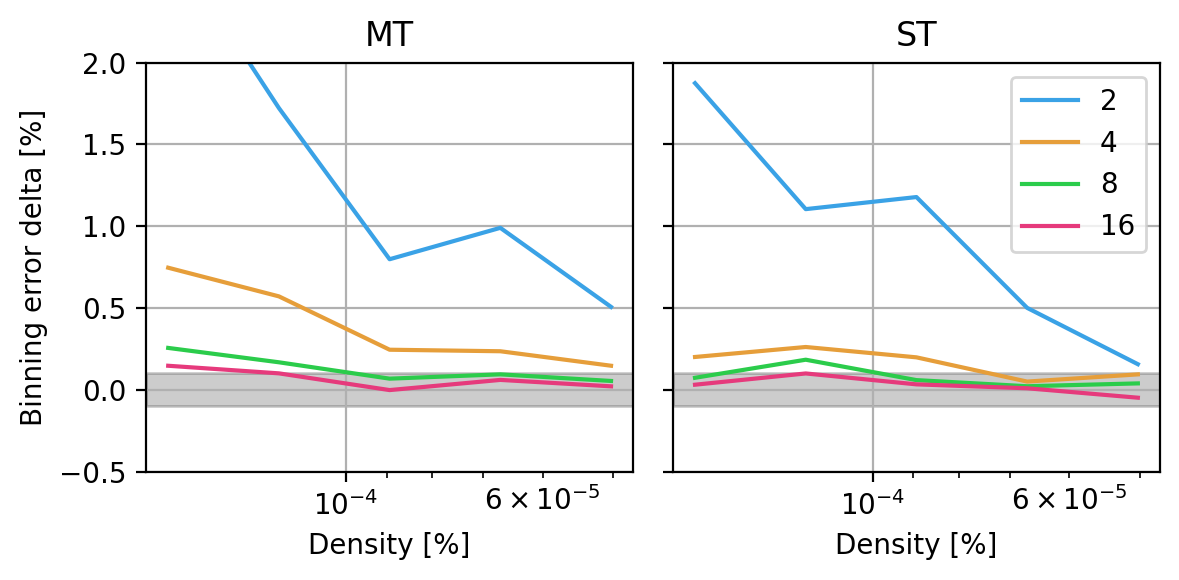

In [13]:
_, axs = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True, sharey=True, dpi=200)
for model_key, ax in zip(["MT", "ST"], axs):
    deltas_for_model = pd.DataFrame([delta[model_key] for delta in deltas_mean_across_seeds])
    for i, bin_count in enumerate(sorted(deltas_for_model)):
        ax.plot(dens, deltas_for_model[bin_count], label=bin_count, color=darken(color_series[i]))
    ax.axhspan(-0.1, 0.1, color="black", alpha=0.2)
    ax.set_title(model_key)
    ax.set_xlabel("Density [%]")
    ax.set_xscale("log")
    ax.invert_xaxis()
    ax.grid()
    ax.set_ylim(-0.5, 2)
axs[-1].legend()
axs[0].set_ylabel("Binning error delta [%]")
plt.savefig("output/bits-in-postsparse.png", facecolor="white")